# Prep run

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
tplot = 0
tsnap = 1

In [3]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1  # test
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
(50, 1350, 270)
10650


In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([3,4,9,10])
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt1 = datetimes[1]-datetimes[0]   # days
dt2 = datetimes[3]-datetimes[2]   # days
dt1 = dt1.total_seconds()
dt2 = dt2.total_seconds()
print(dt1,dt2)
dt = np.array([dt1,dt2])

2678400.0 2592000.0


# Read files and make dataframe
- UVEL, VVEL for vorticity vectors, EXF for wind forcing
- ADV and DF terms
- T and S fields

In [8]:
# read timesteps at index 1 and 3
UVELMASS = np.full((2,nz,ny,nx),np.nan)
VVELMASS = np.full((2,nz,ny,nx),np.nan)
ADVx_TH = np.full((2,nz,ny,nx),np.nan)
ADVy_TH = np.full((2,nz,ny,nx),np.nan)
DFxE_TH = np.full((2,nz,ny,nx),np.nan)
DFyE_TH = np.full((2,nz,ny,nx),np.nan)
ADVx_SLT = np.full((2,nz,ny,nx),np.nan)
ADVy_SLT = np.full((2,nz,ny,nx),np.nan)
DFxE_SLT = np.full((2,nz,ny,nx),np.nan)
DFyE_SLT = np.full((2,nz,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
myi = np.array([1,3])
ii = 0

for i in myi:

    meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[i] + '.meta')
    fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
    varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[0])       # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[1])       # m/s
    ADVx_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])       # m/s
    ADVy_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])       # m/s
    DFxE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])       # m/s
    DFyE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])       # m/s
    ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[6])       # m/s
    ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[7])       # m/s
    DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[8])       # m/s
    DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[9])       # m/s
    
    # reshaping and fixing up
    UVELMASS[ii,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[ii,:,:,:] = VVELMASSi.reshape(nz,ny,nx)
    ADVx_TH[ii,:,:,:] = ADVx_THi.reshape(nz,ny,nx)
    ADVy_TH[ii,:,:,:] = ADVy_THi.reshape(nz,ny,nx)
    DFxE_TH[ii,:,:,:] = DFxE_THi.reshape(nz,ny,nx)
    DFyE_TH[ii,:,:,:] = DFyE_THi.reshape(nz,ny,nx)
    ADVx_SLT[ii,:,:,:] = ADVx_SLTi.reshape(nz,ny,nx)
    ADVy_SLT[ii,:,:,:] = ADVy_SLTi.reshape(nz,ny,nx)
    DFxE_SLT[ii,:,:,:] = DFxE_SLTi.reshape(nz,ny,nx)
    DFyE_SLT[ii,:,:,:] = DFyE_SLTi.reshape(nz,ny,nx)

    ii += 1

In [9]:
# loop through both and make time-average of this

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

# divide first two and second two by dt
theta = np.full((int(len(tsstr)/2),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)/2),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)/2),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)/2),nz,ny,nx),np.nan)

theta[0,:,:,:] = ((THETADR[1,:,:,:]/DRF3d/mygrid['hFacC'] + THETADR[0,:,:,:]/DRF3d/mygrid['hFacC'])/2)  # average of two snaps
theta[1,:,:,:] = ((THETADR[3,:,:,:]/DRF3d/mygrid['hFacC'] + THETADR[2,:,:,:]/DRF3d/mygrid['hFacC'])/2)
dthetadt[0,:,:,:] = (THETADR[1,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[0,:,:,:]/DRF3d/mygrid['hFacC'])/dt1
dthetadt[1,:,:,:] = (THETADR[3,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[2,:,:,:]/DRF3d/mygrid['hFacC'])/dt2

salt[0,:,:,:]  = ((SALTDR[1,:,:,:]/DRF3d/mygrid['hFacC'] + SALTDR[0,:,:,:]/DRF3d/mygrid['hFacC'])/2)
salt[1,:,:,:]  = ((SALTDR[3,:,:,:]/DRF3d/mygrid['hFacC'] + SALTDR[2,:,:,:]/DRF3d/mygrid['hFacC'])/2)
dsaltdt[0,:,:,:] = (SALTDR[1,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[0,:,:,:]/DRF3d/mygrid['hFacC'])/dt1
dsaltdt[1,:,:,:] = (SALTDR[3,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[2,:,:,:]/DRF3d/mygrid['hFacC'])/dt2

In [10]:
# load some surface forcing terms from exf
# load the EXF data from BUDG/exf_zflux_set1
# |EXFtaux |  1 |       |UM      U1|N/m^2           |zonal surface wind stress, >0 increases uVel

# forcings on heat
EXFpreci = np.full((2,ny,nx),np.nan)
EXFevap = np.full((2,ny,nx),np.nan)
EXFroff = np.full((2,ny,nx),np.nan)
EXFempmr = np.full((2,ny,nx),np.nan)

# read timesteps at index 1 and 3
EXFswdn = np.full((2,ny,nx),np.nan)
EXFlwdn = np.full((2,ny,nx),np.nan)
EXFswnet = np.full((2,ny,nx),np.nan)
EXFlwnet = np.full((2,ny,nx),np.nan)
EXFqnet = np.full((2,ny,nx),np.nan)
EXFhs = np.full((2,ny,nx),np.nan)
EXFhl = np.full((2,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
myi = np.array([1,3])
ii = 0

for i in myi:
    meta_exf_zflux_set1= parsemeta(dirIn + "exf_zflux_set1" + '.' + tsstr[i] + '.meta')
    fldlist = np.array(meta_exf_zflux_set1['fldList'])
    # print(fldlist)   # can just start with the quivers of u and v 10m wind
    '''
    EXFpreci: precipitation (+ decrease salt)
    EXFevap: evaporation (+ increase salt)
    EXFroff: runoff (+ decrease salt)
    EXFempmr: upward freshwater flux (+ increase salt)
    
    EXFswdn: shortwave down (+ increase theta)            W/m^2
    EXFlwdn: longwave down (+ increase theta)            W/m^2
    EXFswnet: net sw up (+ decrease theta)            W/m^2
    EXFlwnet: net longwave up (+ decrease theta)            W/m^2
    EXFqnet: net upward heat flux (turb + rad) (+ decrease theta)            W/m^2
    EXFhs: W/m^2 sensible heat flux to ocean(+ increase theta)            W/m^2
    EXFhl: W/m^2 latent heat flux into ocean (+ increase . heta)            W/m^2
    '''
    varnames = np.array(['EXFpreci','EXFevap','EXFroff','EXFempmr','EXFswdn','EXFlwdn','EXFswnet','EXFlwnet','EXFqnet','EXFhs','EXFhl'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    # forcings on salt
    EXFprecii,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[0])
    EXFevapi,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[1])
    EXFroffi,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[2])
    EXFempmri,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[3])
    EXFpreci[ii,:,:] = np.reshape(EXFprecii,(ny,nx))
    EXFevap[ii,:,:] = np.reshape(EXFevapi,(ny,nx))
    EXFroff[ii,:,:] = np.reshape(EXFroffi,(ny,nx))
    EXFempmr[ii,:,:] = np.reshape(EXFempmri,(ny,nx))
    
    # forcings on heat
    EXFswdni,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[4])
    EXFlwdni,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[5])
    EXFswneti,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[6])
    EXFlwneti,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[7])
    EXFqneti,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[8])
    EXFhsi,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[9])
    EXFhli,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[i]),returnmeta=True,rec = recs[10])
    EXFswdn[ii,:,:] = np.reshape(EXFswdni,(ny,nx))
    EXFlwdn[ii,:,:] = np.reshape(EXFlwdni,(ny,nx))
    EXFswnet[ii,:,:] = np.reshape(EXFswneti,(ny,nx))
    EXFlwnet[ii,:,:] = np.reshape(EXFlwneti,(ny,nx))
    EXFqnet[ii,:,:] = np.reshape(EXFqneti,(ny,nx))
    EXFhs[ii,:,:] = np.reshape(EXFhsi,(ny,nx))
    EXFhl[ii,:,:] = np.reshape(EXFhli,(ny,nx))

    ii += 1

In [11]:
# load the EXF data from diags/state_2d_set1
# N/m^2
oceTAUX = np.full((2,ny,nx),np.nan)
oceTAUY = np.full((2,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
myi = np.array([1,3])
ii = 0

for i in myi:
    meta_state_2d_set1= parsemeta(dirState + "state_2d_set1" + '.' + tsstr[i] + '.meta')
    fldlist = np.array(meta_state_2d_set1['fldList'])
    # print(fldlist)   # can just start with the quivers of u and v 10m wind
    varnames = np.array(['oceTAUX','oceTAUY'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    oceTAUXi,its,meta = rdmds(dirState + "state_2d_set1", int(tsstr[i]),returnmeta=True,rec = recs[0])
    oceTAUYi,its,meta = rdmds(dirState + "state_2d_set1", int(tsstr[i]),returnmeta=True,rec = recs[1])

    oceTAUX[ii,:,:] = np.reshape(oceTAUXi,(ny,nx))
    oceTAUY[ii,:,:] = np.reshape(oceTAUYi,(ny,nx))

    ii += 1

In [12]:
# for volume tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

SIheff = np.full((4,ny,nx),np.nan)

for t in range(len(tsstr)):
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[t]+ ".meta")
    # try to read this with rec
    fldlist = np.array(meta_budg2d_snap_set1['fldList'])
    varnames = np.array(['SIheff'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    t1 = tsstr[t]
    read = [int(t1)]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    SIheffi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    
    # choose by basin
    SIheffi = np.reshape(SIheffi,(ny,nx))

    SIheff[t,:,:] = SIheffi

dsiheffdt = np.full((int(len(tsstr)/2),ny,nx),np.nan)
dsiheffdt[0,:,:] = (SIheff[1,:,:]- SIheff[0,:,:])/dt1
dsiheffdt[1,:,:] = (SIheff[3,:,:]- SIheff[2,:,:])/dt2

### get_aste_vector data

In [13]:
# get the vectors of u and v without mass weighting
Uo = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
UadvTH = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
VadvTH = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
UadvSLT = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
VadvSLT = np.full((2,nz,ny-nfy[0],nfx[0]*2),np.nan)
tauU = np.full((2,ny-nfy[0],nfx[0]*2),np.nan)
tauV = np.full((2,ny-nfy[0],nfx[0]*2),np.nan)

for i in range(2):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvTH = ADVx_TH[i]
    tmpVadvTH = ADVy_TH[i]
    tmpUadvSLT = ADVx_SLT[i]
    tmpVadvSLT = ADVy_SLT[i]
    tmpeU = oceTAUX[i]
    tmpeV = oceTAUY[i]

    # get the vectors defined above
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering
    tmpUadvTH,tmpVadvTH = get_aste_vector_face1_3(tmpUadvTH,tmpVadvTH,nfx,nfy,False)
    tmpUadvTH,tmpVadvTH = tmpUadvTH[:,:-1,:-1],tmpVadvTH[:,:-1,:-1]
    tmpUadvSLT,tmpVadvSLT = get_aste_vector_face1_3(tmpUadvSLT,tmpVadvSLT,nfx,nfy,False)
    tmpUadvSLT,tmpVadvSLT = tmpUadvSLT[:,:-1,:-1],tmpVadvSLT[:,:-1,:-1]
    tmpexfU,tmpexfV = get_aste_vector_face1_3(tmpeU,tmpeV,nfx,nfy,False)
    tmpexfU,tmpexfV = tmpexfU[0,:-1,:-1],tmpexfV[0,:-1,:-1]

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    UadvTH[i] = tmpUadvTH
    VadvTH[i] = tmpVadvTH
    UadvSLT[i] = tmpUadvSLT
    VadvSLT[i] = tmpVadvSLT
    tauU[i] = tmpexfU
    tauV[i] = tmpexfV

# Plot some vectors


In [14]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
cmaps = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [15]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)

In [16]:
# plt.quiver(X, Y, u, v, color='r', scale=1, width=0.005)
x = np.arange(0,540,1)
y = np.arange(0,900,1)
X, Y = np.meshgrid(x, y)

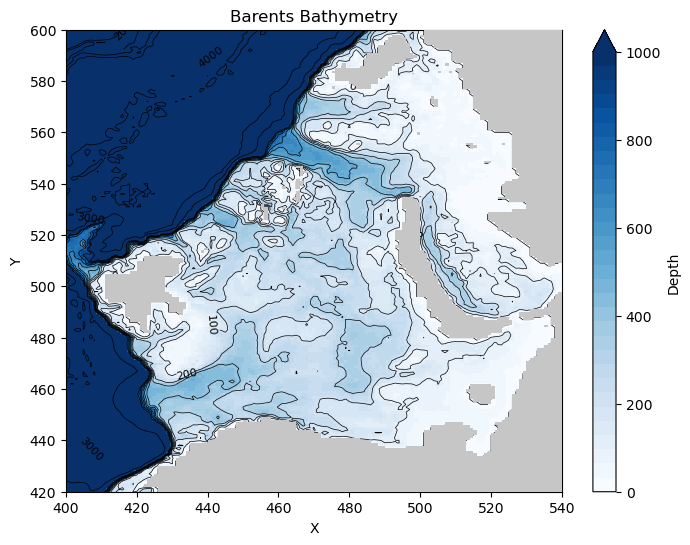

In [18]:
plt.figure(figsize=(8, 6))
# Levels every 100 meters from 0 to 1000 and every 1000 meters from 1000 upwards
levels = np.concatenate([np.arange(0, 1000, 100), np.arange(1000, 6000, 1000)])
pcolor_plot = plt.pcolor(X, Y, get_aste_tracer(DD,nfx,nfy)[0], shading='auto',vmax=1000,cmap=cmap_bath)
# Add colorbar
cbar = plt.colorbar(pcolor_plot, label='Depth',extend="max")
# Add contour lines
contour_lines = plt.contour(X, Y, get_aste_tracer(DD,nfx,nfy)[0], levels=levels, colors='black', linewidths=0.5)
plt.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
# Add labels to the contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
# Add title and axis labels
plt.title('Barents Bathymetry')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(400,540)
plt.ylim(420,600)

plt.savefig(path + "Barents_bathymetry.png",dpi=300)

In [ ]:
# plot face 3 for a single point
x = 25
y = 500



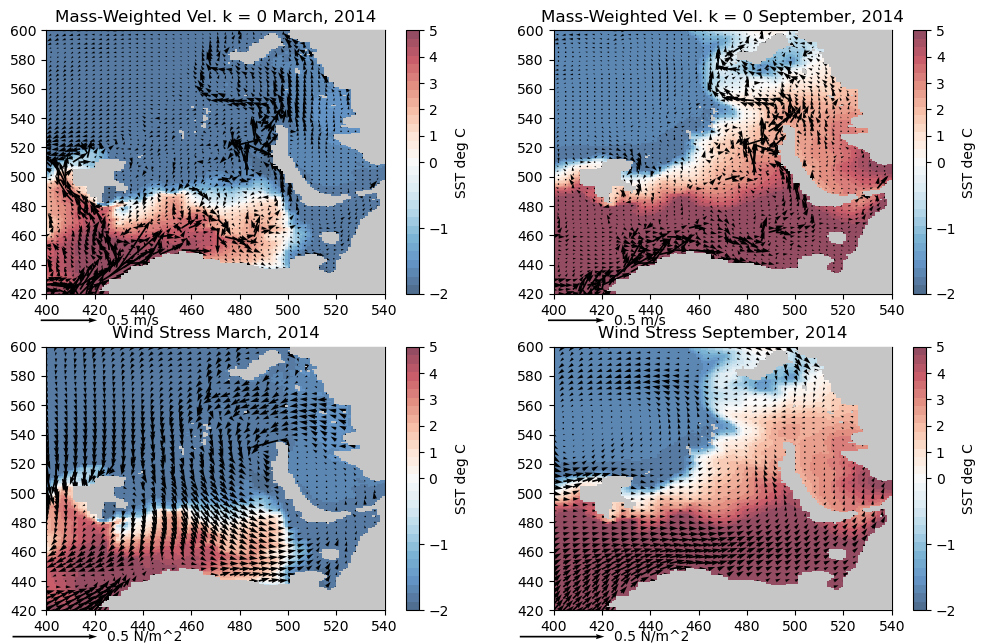

In [16]:
# plot surface velocities with surface winds for the two months
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=5)

fig = plt.figure(figsize=(12,10))
t = 0
ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(theta[t],nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[t][0][::step,::step], Vo[t][0][::step,::step],scale=3,width=0.005,zorder=3)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')
ax.set_title("Mass-Weighted Vel. k = 0 "+datetimes[0].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

t = 1
ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(theta[t],nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[t][0][::step,::step], Vo[t][0][::step,::step],scale=3,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')
ax.set_title("Mass-Weighted Vel. k = 0 "+datetimes[2].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

t = 0
ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(theta[t],nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
Q = ax.quiver(X[::step,::step], Y[::step,::step], tauU[t][::step,::step], tauV[t][::step,::step],scale=2,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 N/m^2', labelpos='E')
ax.set_title("Wind Stress "+datetimes[0].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

t = 1
ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(theta[t],nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
Q = ax.quiver(X[::step,::step], Y[::step,::step], tauU[t][::step,::step], tauV[t][::step,::step],scale=2,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 N/m^2', labelpos='E')
ax.set_title("Wind Stress "+datetimes[2].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

plt.subplots_adjust(bottom=0.3)

plt.savefig(path + "surfaceT_winds.png",dpi=300)

Text(0.5, 1.0, 'September H Density Grad')

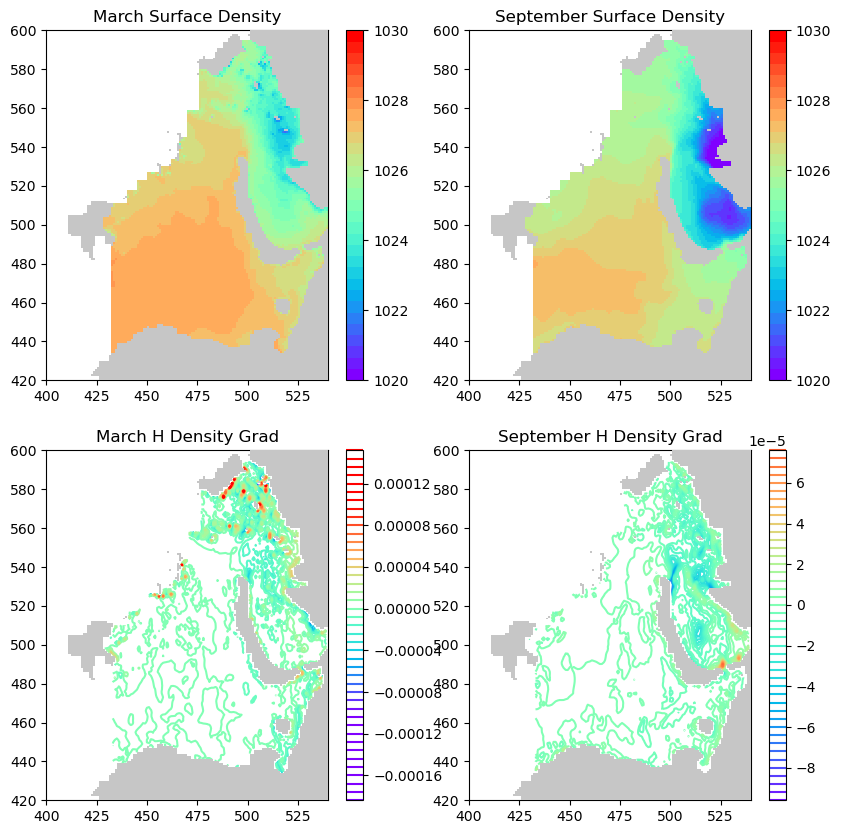

In [24]:
# calculate density field - this should explain lower velocities
THETA1 = THETADR[1,:,:,:]/DRF3d/mygrid['hFacC'] * mymsk /6
SALT1 = SALTDR[1,:,:,:]/DRF3d/mygrid['hFacC'] * mymsk /6

THETA3 = THETADR[3,:,:,:]/DRF3d/mygrid['hFacC'] * mymsk /6
SALT3 = SALTDR[3,:,:,:]/DRF3d/mygrid['hFacC'] * mymsk /6

# get density
dens1=get_aste_tracer(gsw.rho(SALT1[0],THETA1[0],0),nfx,nfy)[0]
dens3=get_aste_tracer(gsw.rho(SALT3[0],THETA3[0],0),nfx,nfy)[0]

# get lateral density gradient from DXG
latdens1grad = (dens1[:,1:] - dens1[:,:-1])
latdens3grad = (dens3[:,1:] - dens3[:,:-1])
latdens1grad_padded = np.pad(latdens1grad, ((0, 0), (1, 0)), mode='constant', constant_values=0)
latdens3grad_padded = np.pad(latdens3grad, ((0, 0), (1, 0)), mode='constant', constant_values=0)
dxg_tracer = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0]
ld1grad = latdens1grad_padded/dxg_tracer
ld3grad = latdens3grad_padded/dxg_tracer

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(221)
cb = ax.pcolormesh(dens1,cmap=cmaps,vmin=1020,vmax=1030)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("March Surface Density")

ax = plt.subplot(222)
cb = ax.pcolormesh(dens3,cmap=cmaps,vmin=1020,vmax=1030)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("September Surface Density")

ax = plt.subplot(223)
cs = ax.contour(ld1grad, cmap='rainbow', levels=50, vmin=-.0001, vmax=.0001)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.colorbar(cs)
ax.set_xlim(400, 540)
ax.set_ylim(420, 600)
ax.set_title("March H Density Grad")

ax = plt.subplot(224)
cs = ax.contour(ld3grad, cmap='rainbow', levels=50, vmin=-.0001, vmax=.0001)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.colorbar(cs)
ax.set_xlim(400, 540)
ax.set_ylim(420, 600)
ax.set_title("September H Density Grad")

plt.savefig(path + "densitygrad_Barents.png",dpi=300)

# Look at surface forcing terms

In [40]:
# EXFswdn
# EXFlwdn
# EXFswnet
# EXFlwnet
# EXFqnet
# EXFhs
# EXFhl

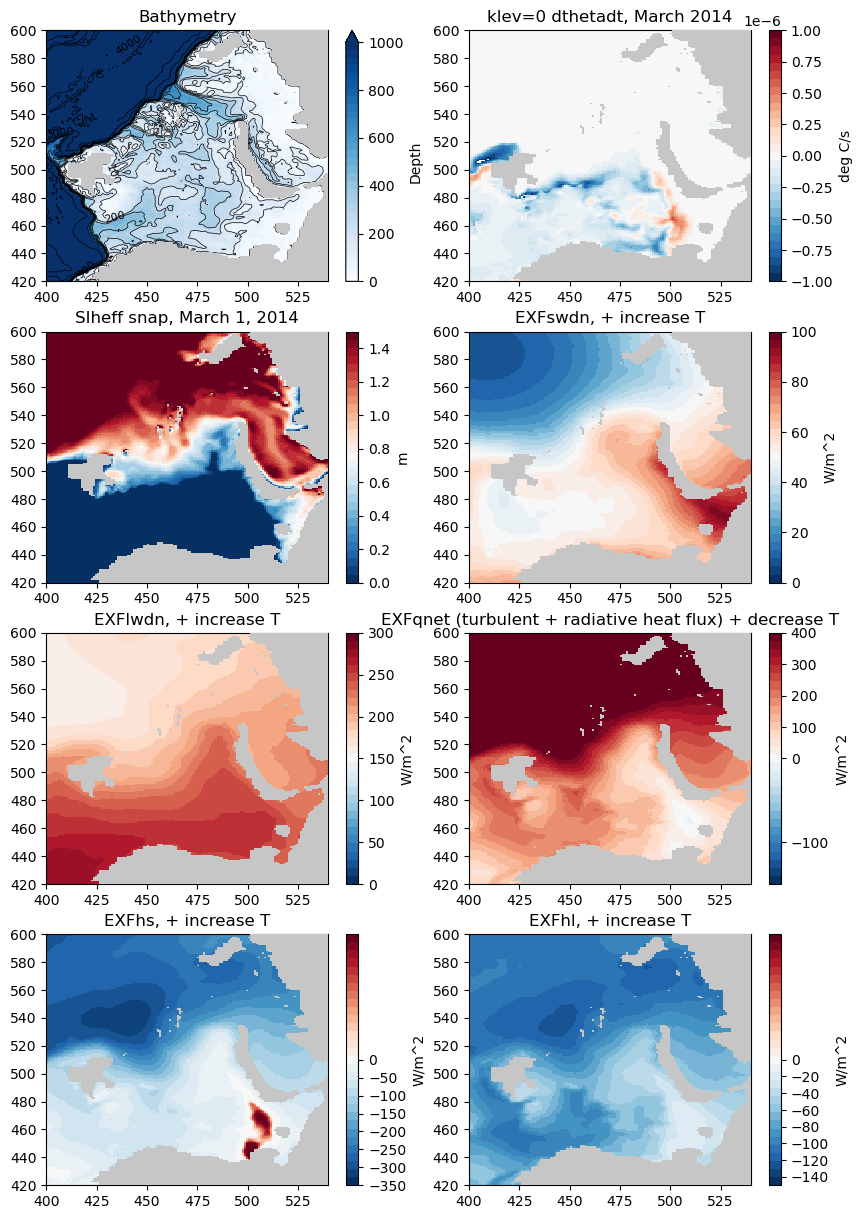

In [41]:
fig = plt.figure(figsize=(10,15))

# bathymetry
ax = plt.subplot(421)
levels = np.concatenate([np.arange(0, 1000, 100), np.arange(1000, 6000, 1000)])
pcolor_plot = ax.pcolor(X, Y, get_aste_tracer(DD,nfx,nfy)[0], shading='auto',vmax=1000,cmap=cmap_bath)
plt.colorbar(pcolor_plot, label='Depth',extend="max")
contour_lines = ax.contour(X, Y, get_aste_tracer(DD,nfx,nfy)[0], levels=levels, colors='black', linewidths=0.5)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.clabel(contour_lines, inline=True, fontsize=8)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("Bathymetry")

# dT field for timesteps of March
ax = plt.subplot(422)
cb = ax.pcolormesh(get_aste_tracer(dthetadt[tplot],nfx,nfy)[0],cmap=cmap,vmin=-1e-6,vmax=1e-6)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("klev=0 dthetadt, March 2014")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="deg C/s")

# sea ice
ax = plt.subplot(423)
cb = ax.pcolormesh(get_aste_tracer(SIheff[tsnap],nfx,nfy)[0],cmap=cmap,vmin=0,vmax=1.5)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("SIheff snap, March 1, 2014")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="m")

# EXFswdn ()
ax = plt.subplot(424)
cb = ax.pcolormesh(get_aste_tracer(EXFswdn[tplot],nfx,nfy)[0],cmap=cmap,vmax=100)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFswdn, + increase T")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFlwdn
ax = plt.subplot(425)
cb = ax.pcolormesh(get_aste_tracer(EXFlwdn[tplot],nfx,nfy)[0],cmap=cmap,vmax=300)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFlwdn, + increase T")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFqnet
ax = plt.subplot(426)
norm = TwoSlopeNorm(vmin=-150,vcenter=0,vmax=400)
cb = ax.pcolormesh(get_aste_tracer(EXFqnet[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFqnet (turbulent + radiative heat flux) + decrease T")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFhs
ax = plt.subplot(427)
norm = TwoSlopeNorm(vmin=-350,vcenter=0,vmax=5)
cb = ax.pcolormesh(get_aste_tracer(EXFhs[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFhs, + increase T")   # sensible heat flux
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFhl
ax = plt.subplot(428)
norm = TwoSlopeNorm(vmin=-150,vcenter=0,vmax=5)
cb = ax.pcolormesh(get_aste_tracer(EXFhl[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFhl, + increase T")   # latent heat flux
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

plt.savefig(path + "surfacefrc_onT_March2014.png",dpi=300)

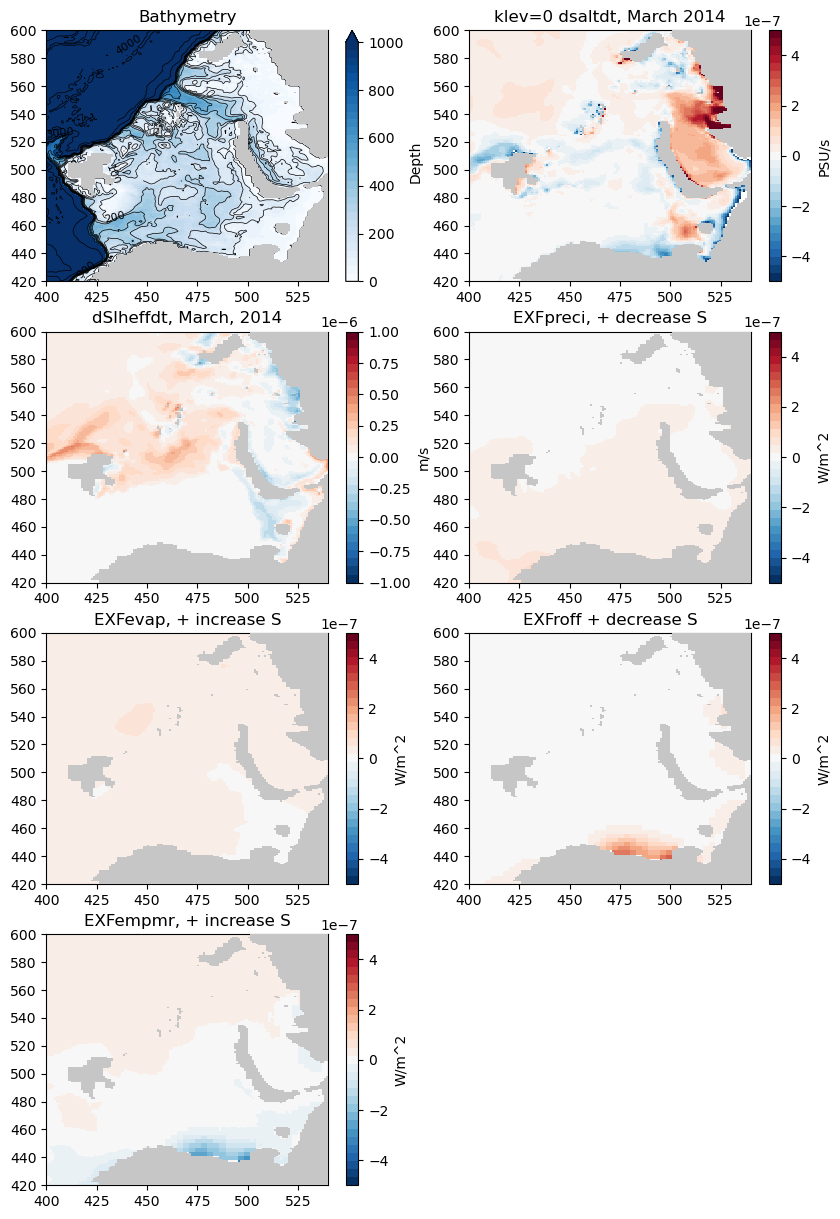

In [57]:
# do the same plot with salinity
fig = plt.figure(figsize=(10,15))


# bathymetry
ax = plt.subplot(421)
levels = np.concatenate([np.arange(0, 1000, 100), np.arange(1000, 6000, 1000)])
pcolor_plot = ax.pcolor(X, Y, get_aste_tracer(DD,nfx,nfy)[0], shading='auto',vmax=1000,cmap=cmap_bath)
plt.colorbar(pcolor_plot, label='Depth',extend="max")
contour_lines = ax.contour(X, Y, get_aste_tracer(DD,nfx,nfy)[0], levels=levels, colors='black', linewidths=0.5)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.clabel(contour_lines, inline=True, fontsize=8)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("Bathymetry")

# dT field for timesteps of March
ax = plt.subplot(422)
cb = ax.pcolormesh(get_aste_tracer(dsaltdt[tplot],nfx,nfy)[0],cmap=cmap,vmin=-5e-7,vmax=5e-7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("klev=0 dsaltdt, March 2014")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="PSU/s")

# sea ice
ax = plt.subplot(423)
cb = ax.pcolormesh(get_aste_tracer(dsiheffdt[tplot],nfx,nfy)[0],cmap=cmap,vmin=-1e-6,vmax=1e-6)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("dSIheffdt, March, 2014")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="m/s")

# EXFswdn ()
ax = plt.subplot(424)
norm = TwoSlopeNorm(vmin=-.5e-6,vcenter=0,vmax=.5e-6)
cb = ax.pcolormesh(get_aste_tracer(EXFpreci[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFpreci, + decrease S")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFlwdn
ax = plt.subplot(425)
norm = TwoSlopeNorm(vmin=-.5e-6,vcenter=0,vmax=.5e-6)
cb = ax.pcolormesh(get_aste_tracer(EXFevap[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFevap, + increase S")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFqnet
ax = plt.subplot(426)
norm = TwoSlopeNorm(vmin=-.5e-6,vcenter=0,vmax=.5e-6)
cb = ax.pcolormesh(get_aste_tracer(EXFroff[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFroff + decrease S")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

# EXFhs
ax = plt.subplot(427)
norm = TwoSlopeNorm(vmin=-.5e-6,vcenter=0,vmax=.5e-6)
cb = ax.pcolormesh(get_aste_tracer(EXFempmr[tplot],nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_title("EXFempmr, + increase S")   # sensible heat flux
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="W/m^2")

plt.savefig(path + "surfacefrc_onS_March2014.png",dpi=300)

In [ ]:
# plot surface velocities with surface winds for the two months
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=5)

fig = plt.figure(figsize=(12,10))
t = 0
ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(salt[t],nfx,nfy)[0],cmap=cmaps,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[t][0][::step,::step], Vo[t][0][::step,::step],scale=3,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')
ax.set_title("Mass-Weighted Vel. k = 0 "+datetimes[0].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(salt[t],nfx,nfy)[0],cmap=cmaps,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
Q = ax.quiver(X[::step,::step], Y[::step,::step], exfU[t][::step,::step], exfV[t][::step,::step],scale=150,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=15, label='15 m/s', labelpos='E')
ax.set_title("10-m wind speed "+datetimes[0].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

t = 1
ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(salt[t],nfx,nfy)[0],cmap=cmaps,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[t][0][::step,::step], Vo[t][0][::step,::step],scale=3,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')
ax.set_title("Mass-Weighted Vel. k = 0 "+datetimes[2].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(salt[t],nfx,nfy)[0],cmap=cmaps,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk[0],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
Q = ax.quiver(X[::step,::step], Y[::step,::step], exfU[t][::step,::step], exfV[t][::step,::step],scale=150,width=0.005)
qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=15, label='15 m/s', labelpos='E')
ax.set_title("10-m wind speed "+datetimes[2].strftime("%B, %Y"))
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

plt.subplots_adjust(bottom=0.3)

plt.savefig(path + "surfaceS_winds.png",dpi=300)

In [ ]:
klev = np.array([0,0,5,5,8,8])
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=8)

num_plots = 6
rows = 3
cols = 2
fig,axes = plt.subplots(rows,cols,figsize=(20,18))
fig.tight_layout(pad=1.0)
axes = axes.flatten()

m = 0 # month
for i in range(num_plots):
    k = klev[i]
    ax = axes[i]

    cb = ax.pcolormesh(get_aste_tracer(theta[m],nfx,nfy)[k],cmap=cmap,norm=norm,alpha=0.7)
    ax.pcolormesh(landmsk[k],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
    Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[m][k][::step,::step], Vo[m][k][::step,::step],scale=3,width=0.005)
    if m == 0:
        ax.set_title("Mass-Weighted Vel. k = "+str(k)+","+datetimes[0].strftime("%B, %Y"))
    else:
        ax.set_title("Mass-Weighted Vel. k = "+str(k)+","+datetimes[2].strftime("%B, %Y"))
    ax.set_xlim(400,540)
    ax.set_ylim(420,600)
    plt.colorbar(cb,label="T deg C")

    if m == 0:
        m = 1
    elif m == 1:
        m = 0

    if i == 4 or i == 5:
        # add arrows
        qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')

# plt.subplots_adjust(bottom=0.3)

# plt.savefig(path + "compT_vel_March_Sep_2014.png",dpi=300)

In [ ]:
klev = np.array([0,0,5,5,8,8])
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=8)

num_plots = 6
rows = 3
cols = 2
fig,axes = plt.subplots(rows,cols,figsize=(20,18))
fig.tight_layout(pad=1.0)
axes = axes.flatten()

m = 0 # month
for i in range(num_plots):
    k = klev[i]
    ax = axes[i]

    cb = ax.pcolormesh(get_aste_tracer(theta[m],nfx,nfy)[k],cmap=cmap,norm=norm,alpha=0.7)
    ax.pcolormesh(landmsk[k],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
    Q = ax.quiver(X[::step,::step], Y[::step,::step], UadvTH[m][k][::step,::step], VadvTH[m][k][::step,::step],scale=5000000,width=0.005)
    if m == 0:
        ax.set_title("TH Advection k = "+str(k)+", "+datetimes[0].strftime("%B, %Y"))
    else:
        ax.set_title("TH Advection k = "+str(k)+", "+datetimes[2].strftime("%B, %Y"))
    ax.set_xlim(400,540)
    ax.set_ylim(420,600)
    plt.colorbar(cb,label="T deg C")

    if m == 0:
        m = 1
    elif m == 1:
        m = 0


    if i == 4 or i ==5:
        print('ok')
        qk = ax.quiverkey(Q, X=0.15, Y=1.02, U=1000000, label='1e6 degC m^3/s', labelpos='E')
        

# plt.savefig(path + "TH_adv_March_Sep_2014.png",dpi=300)

In [ ]:
klev = np.array([0,0,5,5,8,8])
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=8)

num_plots = 6
rows = 3
cols = 2
fig,axes = plt.subplots(rows,cols,figsize=(20,18))
fig.tight_layout(pad=1.0)
axes = axes.flatten()

m = 0 # month
for i in range(num_plots):
    k = klev[i]
    ax = axes[i]

    cb = ax.pcolormesh(get_aste_tracer(salt[m],nfx,nfy)[k],cmap=cmaps,vmin=29,vmax=35,alpha=0.7)
    ax.pcolormesh(landmsk[k],cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
    Q = ax.quiver(X[::step,::step], Y[::step,::step], UadvSLT[m][k][::step,::step], VadvSLT[m][k][::step,::step],scale=30000000,width=0.005)
    if m == 0:
        ax.set_title("SLT Advection k = "+str(k)+", "+datetimes[0].strftime("%B, %Y"))
    else:
        ax.set_title("SLT Advection k = "+str(k)+", "+datetimes[2].strftime("%B, %Y"))
    ax.set_xlim(400,540)
    ax.set_ylim(420,600)
    plt.colorbar(cb,label="T deg C")

    if m == 0:
        m = 1
    elif m == 1:
        m = 0

    if i == 4 or i ==5:
        print('ok')
        qk = ax.quiverkey(Q, X=0.15, Y=1.02, U=5000000, label='5e6 PSU m^3/s', labelpos='E')

# plt.savefig(path + "SLT_adv_March_Sep_2014.png",dpi=300)